In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [173]:
import os
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive 

import arviz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from IPython.display import Image
from matplotlib import gridspec

import myutils as mu

plt.style.use('seaborn-white')
color = '#87ceeb'

In [174]:
def gomcmc(model, data_dict, num_samples=5000):
    rng_key = jax.random.PRNGKey(0)
    # run MCMC
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=1,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, **data_dict)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc

In [175]:
def get_samples(mcmc):
    if isinstance(mcmc, dict):
        s = mcmc
    else:
        s = mcmc.get_samples()
    d = {}
    for k, v in s.items():
        if len(v.shape) == 2:
            for i in range(v.shape[1]):
                d[f'{k}_{i}'] = np.array(v[:,i])
        else: # len(v.shape) == 1
            d[k] = np.array(v)
    return d

# Chapter 9. Hierarchical Models: Multiple Coins Single Mint
- Grid approximation is not included here.
    - Should be done; it is really pedagogical.
- A single coin form a single mint 
- Multiple coins from a single mint
- Therapeutic touch
- Extending the Hierarchy: Subjects within Categories
    - Baseball batting abilities by position

##  Ch.9.1. A single coin from a single mint

- Likelihood
$$
    y_i \sim \mathrm{Bernoulli}(\theta)
$$
- Prior
$$
    \theta \sim \mathrm{Beta}(a,b)
$$
- Given the mode and concentration, $(\omega, \kappa)$,
\begin{align}
    a &= \omega (\kappa - 2) + 1 \\
    b &= (1 - \omega) (\kappa - 2) + 1
\end{align}
- Prior in $(\omega, \kappa)$:
$$
    \theta \sim \mathrm{Beta}\big(\omega (\kappa - 2) + 1, (1 - \omega) (\kappa - 2) + 1 \big)
$$

- The sample value of $\theta$ depends on $\omega$, which specifies the peak of Beta distribution. 
    - Let's define a prior on $\omega$:
$$
    \omega \sim \mathrm{Beta}(A_\omega, B_\omega)
$$
- The magnitue of $\kappa$ is an expression of our prior certainty regarding the depndence of $\theta$ on $\omega$:

$$
    \kappa = \kappa_{m-2} + 2  \quad \kappa > 2 \\
    \kappa_{m-2} \sim \mathrm{Gamma}(0.01, 0.01) \quad \kappa_{m-2} > 0    
$$

- Givn an observation of 9 heads and 3 tails, the prior and likelihood are:
\begin{align}
    p(\omega, \theta) & = p(\omega) p(\theta | \omega) \\
                        &= \mathrm{Beta}(\omega|2,2) 
                          \mathrm{Beta}(\theta| \omega  (K - 2) + 1, (1-\omega)  (K - 2) + 1) \\
    p(\{y_i\} | \theta) &= \theta^9 (1-\theta)^3
\end{align}
- Posterior Distribution:
\begin{align}
    p(\omega, \theta| Y) & = {p(Y|\omega,\theta)p(\omega, \theta)}\big/{p(Y)} \\
                         & = {p(Y|\theta)p(\theta|\omega)p(\omega)}\bigg/{\iint_{\omega,\theta}p(Y|\theta)p(\theta|\omega)p(\omega) d\omega d\theta} 
\end{align}


### Data

In [5]:
df = pd.read_csv('Data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [6]:
df

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01
...,...,...
275,1,S28
276,1,S28
277,1,S28
278,0,S28


In [181]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))
print(df_proportions.values)
theta_obs = df.groupby('s')['y'].sum() / df.s.value_counts() ## the same thing

[0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.6 0.6 0.7 0.7 0.7 0.8]


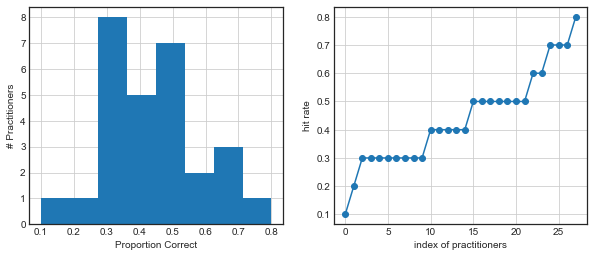

In [185]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

ax=df_proportions.plot(kind='hist', bins=8, ax=axes[0])
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners'); ax.grid()

ax=axes[1]
ax.plot(df_proportions.values, 'o-');
ax.set(ylabel='hit rate', xlabel='index of practitioners'); ax.grid()

In [8]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size
print(practitioner_idx[:20], practitioner_idx.shape)
print(practitioner_codes[:10])
print('n_practitioners: ', n_practitioners)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] (280,)
Index(['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10'], dtype='object')
n_practitioners:  28


### Model

In [9]:
def model_mcsm(n_coins, y=None, coin_ids=None):
#     print(n_coins, y, coin_ids)
    """ len(y) == len(coin_id) """
    Aw, Bw = 1, 1
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    #
    km2 = numpyro.sample('km2', dist.Gamma(concentration=.01, rate=.01))
    K = km2 + 2
    numpyro.deterministic('kappa', K)
    #
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    with numpyro.plate(f'N={n_coins}', size=n_coins):
        theta = numpyro.sample('theta', dist.Beta(a, b))
    #   
    theta_subj = theta[coin_ids]
    #
    size_y = 1 if y is None else len(y)
    with numpyro.plate(f'N={size_y}', size=size_y):  # we can do this without plate command.
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta_subj), obs=y)

In [10]:
# Draw Graphical Model

#### Prior Predictive Check

In [11]:
predictive = Predictive(model_mcsm, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), **dict(n_coins=n_practitioners, y=None, coin_ids=None))
samples_pred

{'kappa': DeviceArray([2.       , 2.       , 2.       , ..., 2.       , 2.0000002,
              2.       ], dtype=float32),
 'km2': DeviceArray([1.17549435e-36, 1.17549435e-36, 1.17549435e-36, ...,
              1.17549435e-36, 1.41871112e-07, 1.17549435e-36],            dtype=float32),
 'omega': DeviceArray([0.32805818, 0.4368664 , 0.5165492 , ..., 0.09381168,
              0.5408726 , 0.26167986], dtype=float32),
 'theta': DeviceArray([[0.00810528, 0.694891  , 0.8099703 , ..., 0.5138037 ,
               0.12171847, 0.8470259 ],
              [0.03217958, 0.09920084, 0.2849171 , ..., 0.9428797 ,
               0.27154818, 0.96095484],
              [0.98984843, 0.6109122 , 0.747864  , ..., 0.48701715,
               0.47499126, 0.63402295],
              ...,
              [0.9562009 , 0.25612584, 0.88617116, ..., 0.93185973,
               0.68645734, 0.05136233],
              [0.98258394, 0.64778274, 0.6514271 , ..., 0.3879044 ,
               0.7125373 , 0.7764521 ],
            

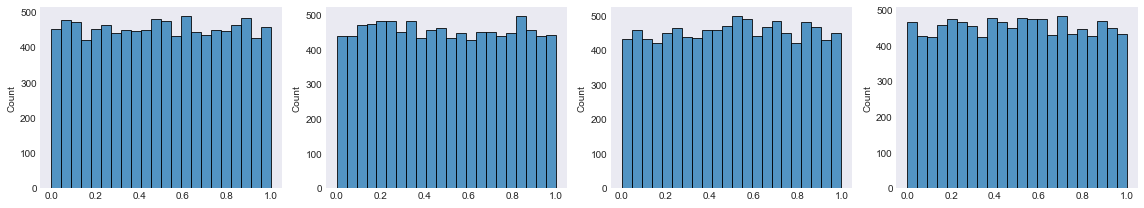

In [12]:
mu.plot_hists(samples_pred['theta'][:,:4]);  # check only 4

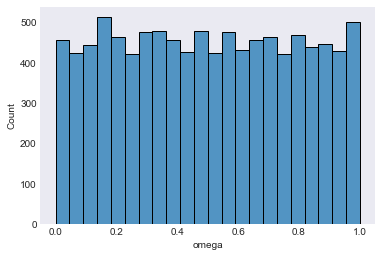

In [13]:
df_pred = pd.DataFrame({'omega': samples_pred['omega'], 'kappa': samples_pred['kappa']})
sns.histplot(df_pred['omega']);

In [124]:
def plot_thetas(trace, theta_obs=None, kappaomega=True):
    import arviz as az
    plt.figure(figsize=(10,12))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[0,:3])
    ax2 = plt.subplot(gs[0,3:])
    ax3 = plt.subplot(gs[1,:2])
    ax4 = plt.subplot(gs[1,2:4])
    ax5 = plt.subplot(gs[1,4:6])
    ax6 = plt.subplot(gs[2,:2])                     
    ax7 = plt.subplot(gs[2,2:4])
    ax8 = plt.subplot(gs[2,4:6])
    ax9 = plt.subplot(gs[3,:2])
    ax10 = plt.subplot(gs[3,2:4])
    ax11 = plt.subplot(gs[3,4:6])

    # thetas and theta pairs to plot
    thetas = (0, 13, 27)
    theta_pairs = ((0,13),(0,27),(13,27))

    font_d = {'size':14}

    # kappa & omega posterior plots
    if kappaomega:
        for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
            az.plot_posterior(trace[var], point_estimate='mode', 
                            ref_val=.5 if var=='omega' else None,
                            hdi_prob=.95,
                            ax=ax, color=color, round_to=2)
            ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
            ax.set(title=None)

        ax1.set(xlim=(0,300))
    #
    # theta posterior plots
    for var, ax in zip(thetas,[ax3, ax7, ax11]):
        az.plot_posterior(trace[f'theta_{var}'], point_estimate='mode', 
                        ref_val=.5,
                        hdi_prob=.95,
                        ax=ax, color=color)
        if theta_obs is not None:
            ax.plot([theta_obs[var]], [0.01], '+', markersize=15, markeredgewidth=2, markerfacecolor='#a0a0f0')
        ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)
        ax.set(title=None)

    # theta scatter plots
    for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
        ax.scatter(trace[f'theta_{var[0]}'], trace[f'theta_{var[1]}'], 
                alpha=0.75, color=color, facecolor='none')
        ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
        ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
        ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
        ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')
        ax.set(title=None)

    # theta posterior differences plots
    for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
        az.plot_posterior(trace[f'theta_{var[0]}']-trace[f'theta_{var[1]}'], 
                        point_estimate='mode', 
                        ref_val=0.,
                        hdi_prob=.95,
                        ax=ax, color=color)
        ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)
        ax.set(title=None)

    plt.suptitle('Figure 9.10 Marginal posterior distributions for the therapeutic touch data.')
    plt.tight_layout()

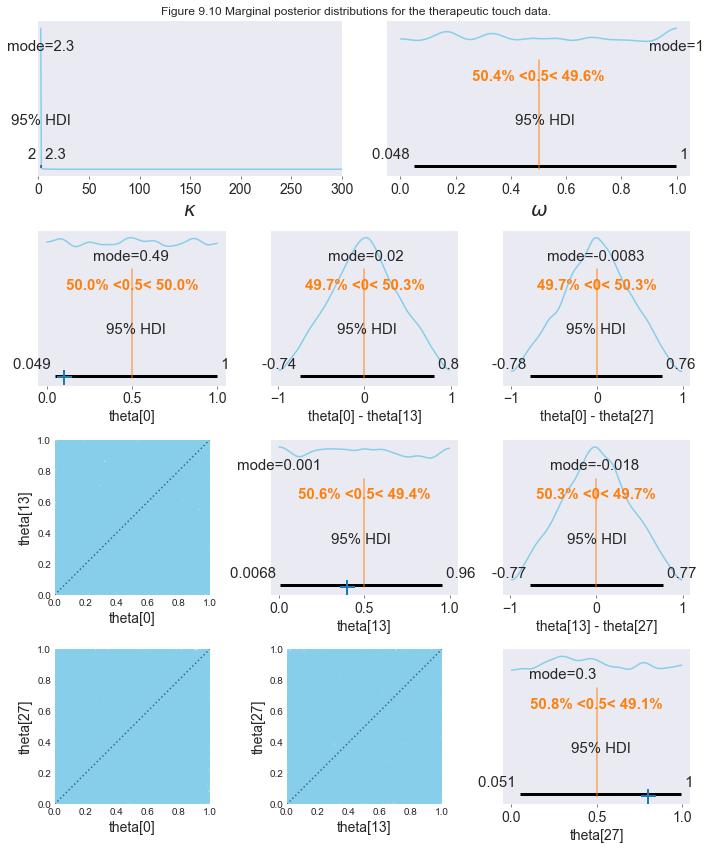

In [15]:
trace = get_samples(samples_pred)
plot_thetas(trace, theta_obs=df_proportions)

#### MCMC Inference

In [16]:
data_dict=dict(n_coins=n_practitioners, y=df.y.values, coin_ids=practitioner_idx)
mcmc = gomcmc(model_mcsm, data_dict)

sample: 100%|██████████| 6000/6000 [00:08<00:00, 692.11it/s, 15 steps of size 2.63e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa     54.82     49.78     38.45      4.37    116.89    506.06      1.00
       km2     52.82     49.78     36.45      2.37    114.89    506.06      1.00
     omega      0.44      0.04      0.44      0.38      0.50   1704.62      1.00
  theta[0]      0.36      0.09      0.37      0.22      0.51   1516.62      1.00
  theta[1]      0.38      0.08      0.39      0.25      0.52   2407.35      1.00
  theta[2]      0.41      0.08      0.41      0.28      0.54   3341.21      1.00
  theta[3]      0.41      0.08      0.41      0.27      0.53   2457.19      1.00
  theta[4]      0.41      0.08      0.41      0.28      0.54   2915.64      1.00
  theta[5]      0.41      0.08      0.41      0.27      0.53   3960.62      1.00
  theta[6]      0.41      0.08      0.41      0.28      0.54   3396.88      1.00
  theta[7]      0.41      0.08      0.41      0.28      0.53   3058.92      1.00
  theta[8]      0.41      0

In [17]:
samples = get_samples(mcmc)
samples

{'kappa': array([ 9.855581, 11.927099, 31.153086, ..., 23.241966, 17.623802,
        22.71208 ], dtype=float32),
 'km2': array([ 7.855581,  9.927099, 29.153086, ..., 21.241966, 15.623802,
        20.71208 ], dtype=float32),
 'omega': array([0.41981605, 0.41324732, 0.37369752, ..., 0.47908834, 0.45019892,
        0.3942445 ], dtype=float32),
 'theta_0': array([0.23787649, 0.41017926, 0.24900375, ..., 0.44804353, 0.267361  ,
        0.26610142], dtype=float32),
 'theta_1': array([0.19555041, 0.55099946, 0.20397079, ..., 0.27600145, 0.44984877,
        0.3186959 ], dtype=float32),
 'theta_2': array([0.32281277, 0.27519244, 0.47486833, ..., 0.4983487 , 0.38169095,
        0.50529456], dtype=float32),
 'theta_3': array([0.2500306 , 0.31448996, 0.42775345, ..., 0.3574249 , 0.40124094,
        0.28028724], dtype=float32),
 'theta_4': array([0.37982982, 0.3864272 , 0.38148102, ..., 0.53062457, 0.20166032,
        0.33817446], dtype=float32),
 'theta_5': array([0.45350072, 0.41357738, 0.3634230

/home/yndk/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  warnings.warn(


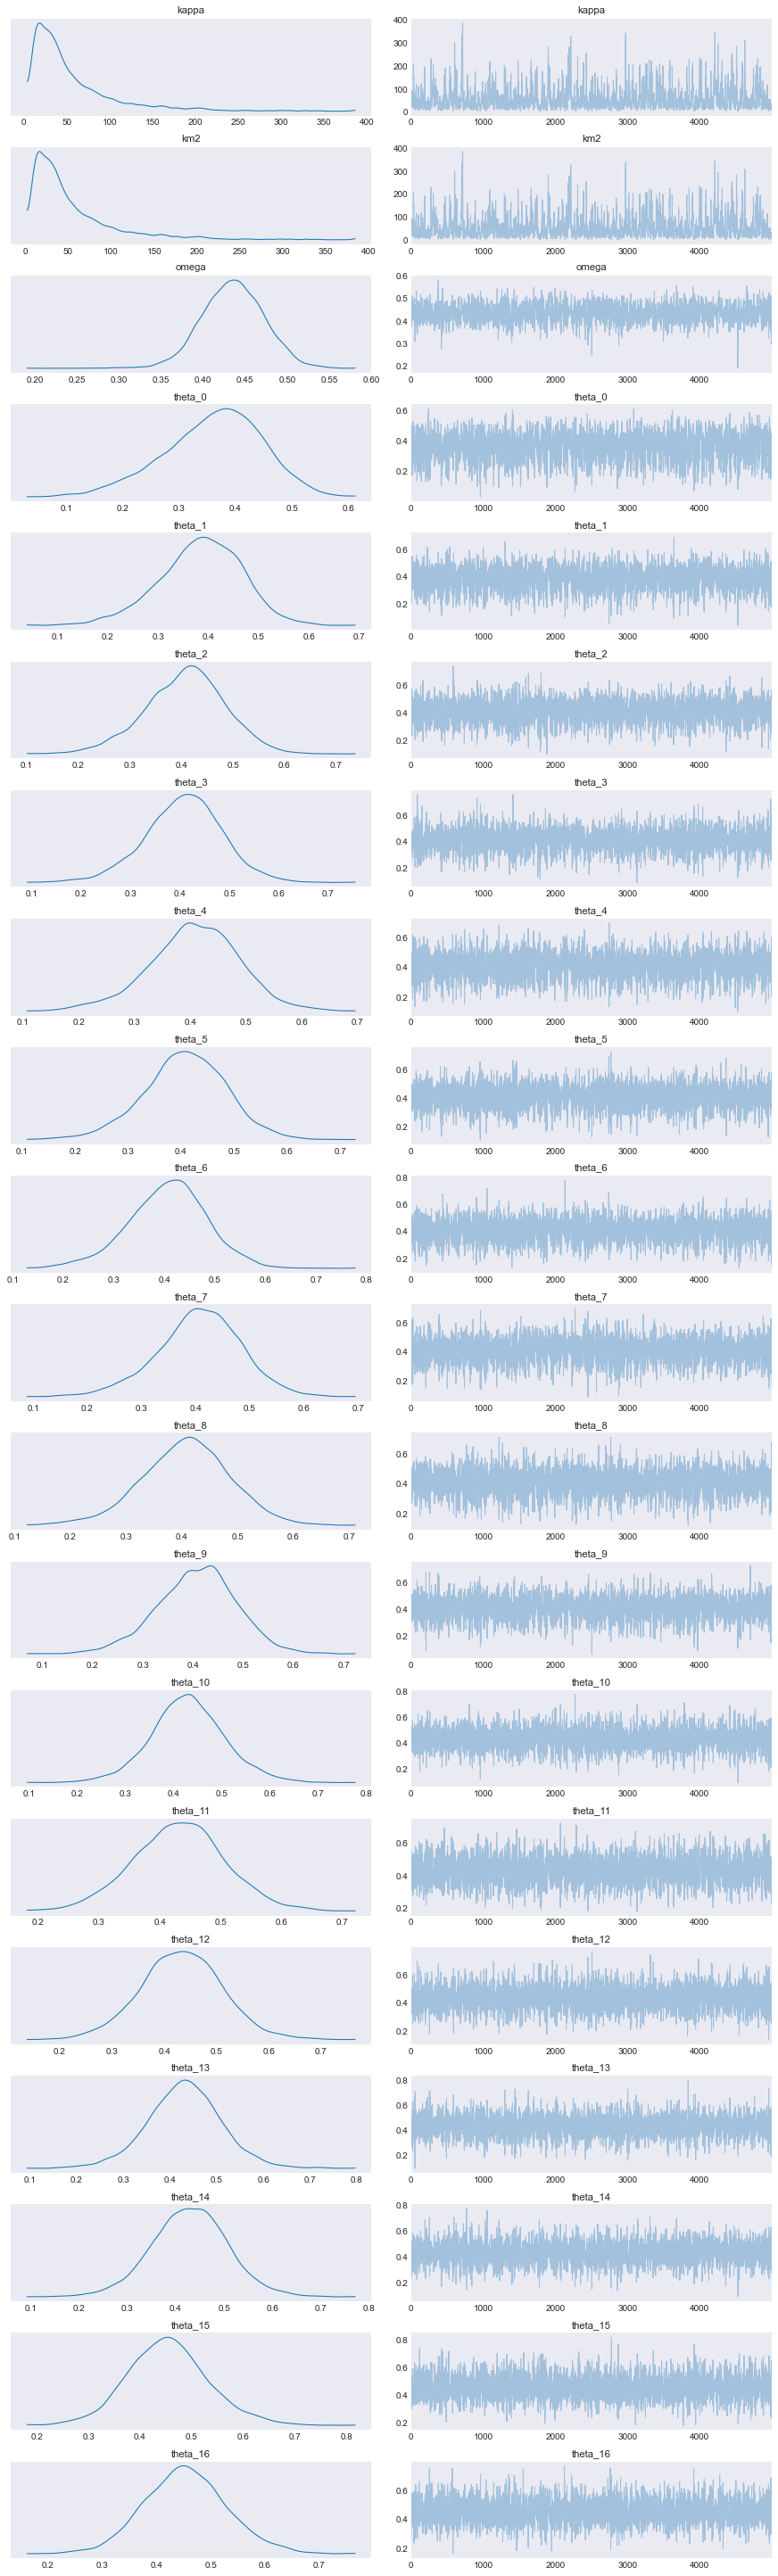

In [18]:
arviz.plot_trace(arviz.from_dict(samples));

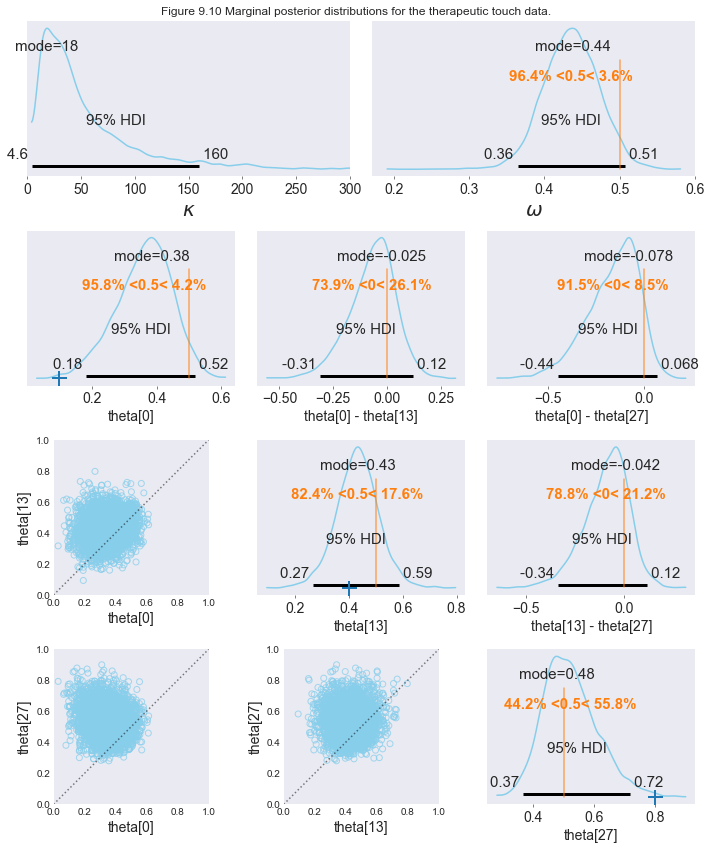

In [19]:
trace = get_samples(samples)
plot_thetas(trace, theta_obs=df_proportions)

---

### Another model with a modified setting

#### New Model with Uniform Distribution

In [20]:
def model_mcsm_uniform(n_coins, y=None, coin_ids=None):
#     print(n_coins, y, coin_ids)
    """ len(y) == len(coin_id) """
    Aw, Bw = 1, 1
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    #
    u = numpyro.sample('uniform', dist.Uniform())
    K = u*300 + 2
    numpyro.deterministic('kappa', K)
    #
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    with numpyro.plate(f'N={n_coins}', size=n_coins):
        theta = numpyro.sample('theta', dist.Beta(a, b))
    #   
    theta_subj = theta[coin_ids]
    #
    size_y = 1 if y is None else len(y)
    with numpyro.plate(f'N={size_y}', size=size_y):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta_subj), obs=y)

#### Prior Predictive Check

In [21]:
predictive = Predictive(model_mcsm_uniform, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), **dict(n_coins=n_practitioners, y=None, coin_ids=None))
samples_pred

{'kappa': DeviceArray([276.0169  ,  99.22979 , 165.7788  , ..., 201.29604 ,
               13.173904, 280.71414 ], dtype=float32),
 'omega': DeviceArray([0.32805818, 0.4368664 , 0.5165492 , ..., 0.09381168,
              0.5408726 , 0.26167986], dtype=float32),
 'theta': DeviceArray([[0.27922887, 0.34807295, 0.36195976, ..., 0.32303056,
               0.30894014, 0.34466237],
              [0.3458539 , 0.39975363, 0.3939413 , ..., 0.49591568,
               0.3461966 , 0.48288977],
              [0.6066427 , 0.52653867, 0.4779644 , ..., 0.486651  ,
               0.51427644, 0.47561613],
              ...,
              [0.08032452, 0.10133475, 0.13706608, ..., 0.14066629,
               0.09941453, 0.06187194],
              [0.6462422 , 0.6597893 , 0.67892176, ..., 0.45492774,
               0.594989  , 0.6755249 ],
              [0.27317497, 0.25572082, 0.28969273, ..., 0.24413063,
               0.2689514 , 0.29683357]], dtype=float32),
 'uniform': DeviceArray([0.9133897 , 0.324099

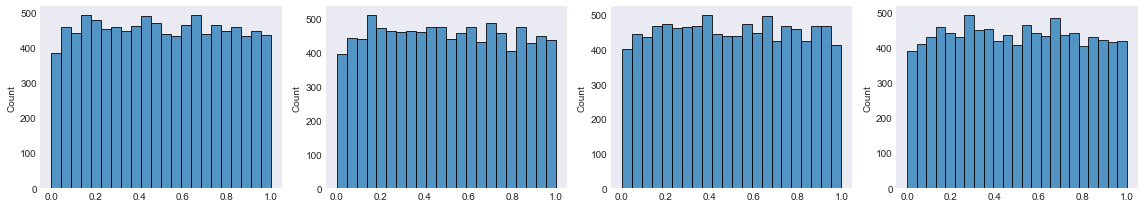

In [22]:
mu.plot_hists(samples_pred['theta'][:,:4]);  # check only 4

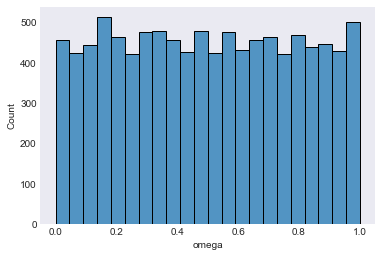

In [23]:
df_pred = pd.DataFrame({'omega': samples_pred['omega'], 'kappa': samples_pred['kappa']})
sns.histplot(df_pred['omega']);

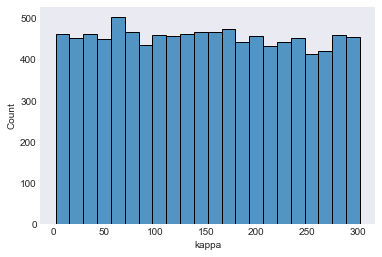

In [24]:
sns.histplot(df_pred['kappa']);

#### MCMC Inference

In [25]:
data_dict=dict(n_coins=n_practitioners, y=df.y.values, coin_ids=practitioner_idx)
mcmc = gomcmc(model_mcsm_uniform, data_dict, num_samples=20000)

sample: 100%|██████████| 21000/21000 [00:27<00:00, 754.50it/s, 15 steps of size 1.77e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa    157.16     82.22    156.39     26.56    282.01   1425.25      1.00
     omega      0.44      0.03      0.44      0.39      0.49   2131.72      1.00
  theta[0]      0.41      0.06      0.41      0.32      0.51   3814.06      1.00
  theta[1]      0.42      0.06      0.42      0.33      0.51   4385.69      1.00
  theta[2]      0.43      0.05      0.43      0.34      0.52   5483.76      1.00
  theta[3]      0.43      0.05      0.43      0.34      0.52   5698.21      1.00
  theta[4]      0.43      0.06      0.43      0.34      0.52   5501.78      1.00
  theta[5]      0.43      0.06      0.43      0.34      0.52   5481.02      1.00
  theta[6]      0.43      0.05      0.43      0.34      0.52   5612.01      1.00
  theta[7]      0.43      0.05      0.43      0.34      0.52   5117.47      1.00
  theta[8]      0.43      0.05      0.43      0.34      0.52   5170.25      1.00
  theta[9]      0.43      0

In [26]:
samples = get_samples(mcmc)

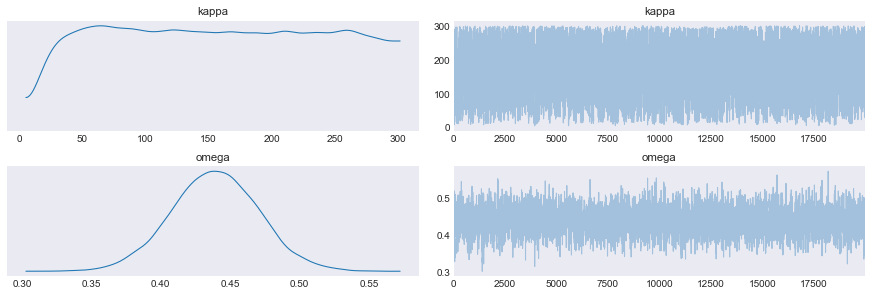

In [27]:
arviz.plot_trace({'kappa': samples['kappa'], 'omega': samples['omega']});

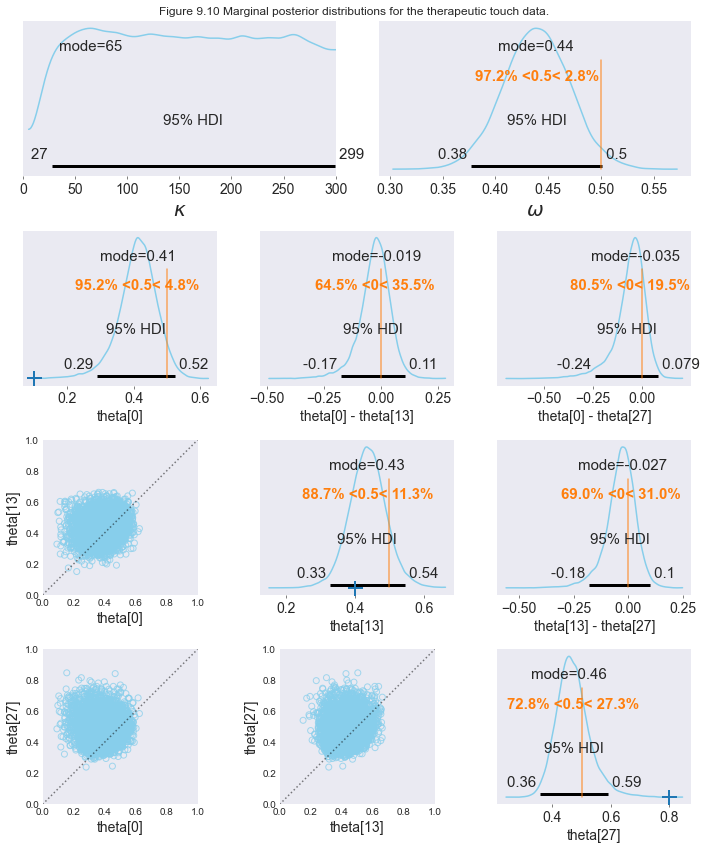

In [28]:
trace = get_samples(samples)
plot_thetas(trace, theta_obs=df_proportions)

#### New Model with Exponential Distribution

In [29]:
def model_mcsm_exp(n_coins, y=None, coin_ids=None):
#     print(n_coins, y, coin_ids)
    """ len(y) == len(coin_id) """
    Aw, Bw = 1, 1
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    #
    u = numpyro.sample('exp', dist.Exponential(rate=1./10.))
    K = u + 2
    numpyro.deterministic('kappa', K)
    #
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    with numpyro.plate(f'N={n_coins}', size=n_coins):
        theta = numpyro.sample('theta', dist.Beta(a, b))
    #   
    theta_subj = theta[coin_ids]
    #
    size_y = 1 if y is None else len(y)
    with numpyro.plate(f'N={size_y}', size=size_y):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta_subj), obs=y)

#### Prior Predictive Check

In [30]:
predictive = Predictive(model_mcsm_exp, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), **dict(n_coins=n_practitioners, y=None, coin_ids=None))

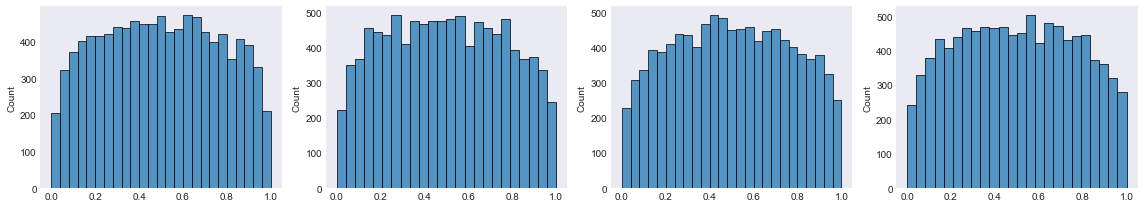

In [31]:
mu.plot_hists(samples_pred['theta'][:,:4]);  # check only 4

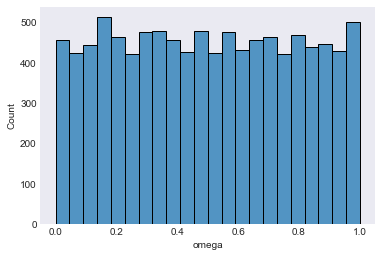

In [32]:
df_pred = pd.DataFrame({'omega': samples_pred['omega'], 'kappa': samples_pred['kappa']})
sns.histplot(df_pred['omega']);

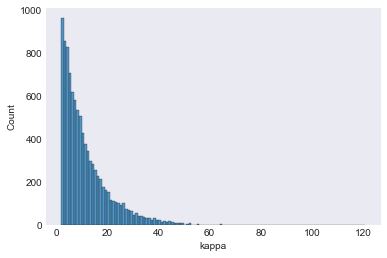

In [33]:
sns.histplot(df_pred['kappa']);

#### MCMC Inference

In [34]:
data_dict=dict(n_coins=n_practitioners, y=df.y.values, coin_ids=practitioner_idx)
mcmc = gomcmc(model_mcsm_exp, data_dict)

sample: 100%|██████████| 6000/6000 [00:08<00:00, 705.38it/s, 15 steps of size 3.29e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       exp     20.87     12.25     18.23      3.99     36.72   1353.12      1.00
     kappa     22.87     12.25     20.23      5.99     38.72   1353.12      1.00
     omega      0.43      0.04      0.43      0.37      0.50   3151.40      1.00
  theta[0]      0.32      0.09      0.32      0.17      0.48   4305.31      1.00
  theta[1]      0.36      0.09      0.36      0.20      0.50   6155.26      1.00
  theta[2]      0.39      0.09      0.39      0.24      0.54   6795.50      1.00
  theta[3]      0.39      0.09      0.39      0.24      0.54   7238.46      1.00
  theta[4]      0.39      0.09      0.39      0.23      0.54   5704.75      1.00
  theta[5]      0.39      0.09      0.39      0.24      0.54   7396.16      1.00
  theta[6]      0.39      0.09      0.39      0.24      0.54   5954.27      1.00
  theta[7]      0.39      0.09      0.39      0.24      0.53   6108.27      1.00
  theta[8]      0.39      0

In [35]:
samples = get_samples(mcmc)

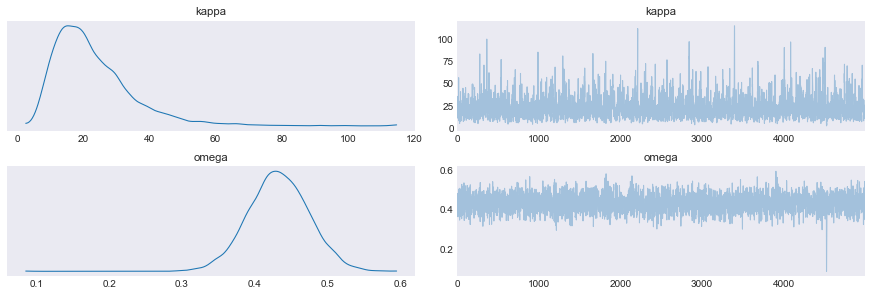

In [36]:
arviz.plot_trace({'kappa': samples['kappa'], 'omega': samples['omega']});

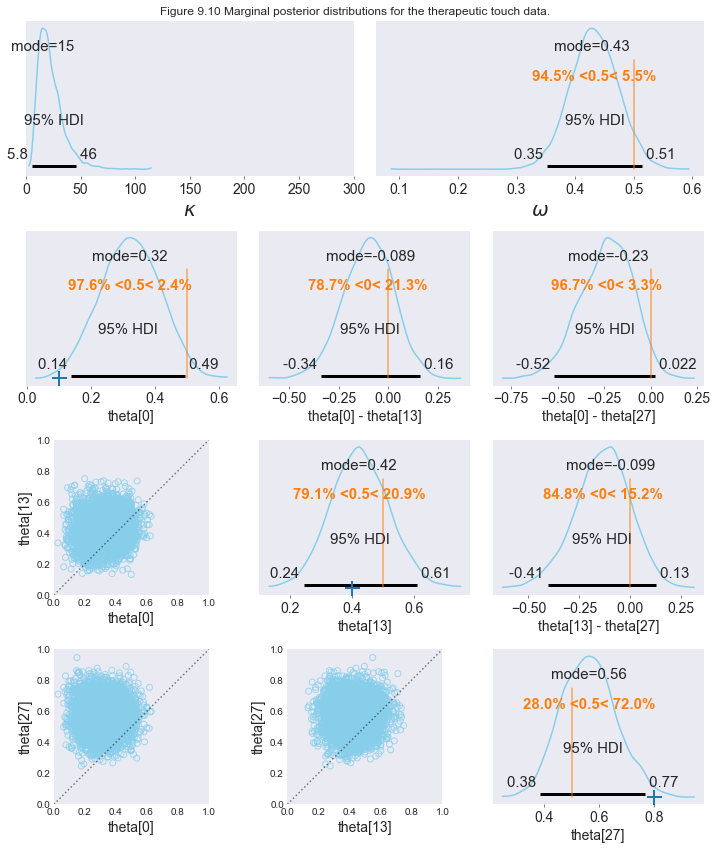

In [37]:
trace = get_samples(samples)
plot_thetas(trace, theta_obs=df_proportions)

#### New Model with Pareto Distribution

(DeviceArray(2.0000205, dtype=float32), DeviceArray(95.03214, dtype=float32))

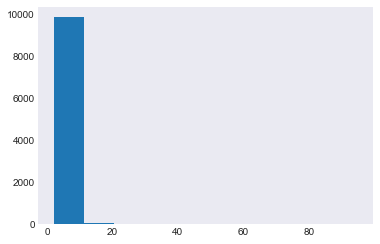

In [50]:
with numpyro.handlers.seed(rng_seed=jax.random.PRNGKey(0)):
    with numpyro.plate('plate', size=10000):
        s = numpyro.sample('pareto', dist.Pareto(scale=2, alpha=2.5))
plt.hist(s);
s.min(), s.max()

In [51]:
def model_mcsm_pareto(n_coins, y=None, coin_ids=None):
#     print(n_coins, y, coin_ids)
    """ len(y) == len(coin_id) """
    Aw, Bw = 1, 1
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    #
    u = numpyro.sample('pareto', dist.Pareto(scale=2, alpha=2.))
    K = u
    numpyro.deterministic('kappa', K)
    #
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    with numpyro.plate(f'N={n_coins}', size=n_coins):
        theta = numpyro.sample('theta', dist.Beta(a, b))
    #   
    theta_subj = theta[coin_ids]
    #
    size_y = 1 if y is None else len(y)
    with numpyro.plate(f'N={size_y}', size=size_y):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta_subj), obs=y)

#### Prior Predictive Check

In [52]:
predictive = Predictive(model_mcsm_pareto, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), **dict(n_coins=n_practitioners, y=None, coin_ids=None))

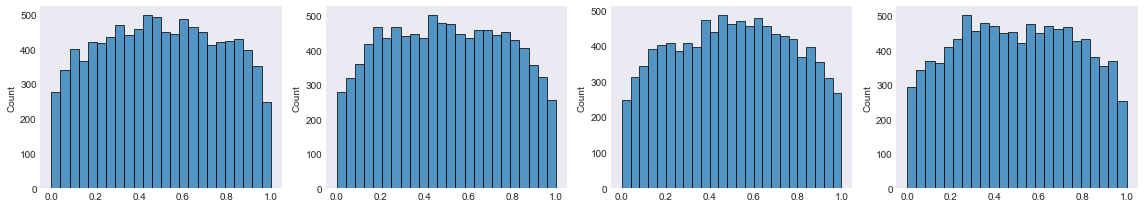

In [53]:
mu.plot_hists(samples_pred['theta'][:,:4]);  # check only 4

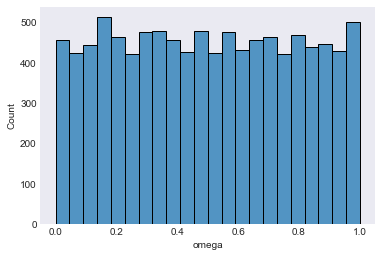

In [54]:
df_pred = pd.DataFrame({'omega': samples_pred['omega'], 'kappa': samples_pred['kappa']})
sns.histplot(df_pred['omega']);

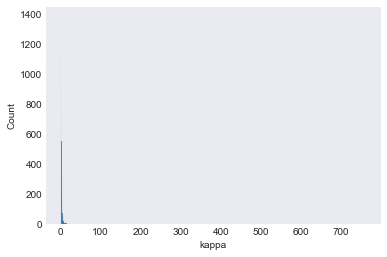

In [55]:
sns.histplot(df_pred['kappa']);

#### MCMC Inference

In [56]:
data_dict=dict(n_coins=n_practitioners, y=df.y.values, coin_ids=practitioner_idx)
mcmc = gomcmc(model_mcsm_pareto, data_dict)

sample: 100%|██████████| 6000/6000 [00:09<00:00, 664.95it/s, 15 steps of size 2.64e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa     20.23     17.75     14.98      2.78     38.16    258.18      1.00
     omega      0.43      0.05      0.43      0.36      0.51   1312.77      1.00
    pareto     20.23     17.75     14.98      2.78     38.16    258.18      1.00
  theta[0]      0.30      0.10      0.30      0.14      0.47   2146.13      1.00
  theta[1]      0.35      0.10      0.35      0.18      0.51   3035.24      1.00
  theta[2]      0.39      0.10      0.39      0.22      0.54   5844.43      1.00
  theta[3]      0.38      0.10      0.38      0.22      0.54   4298.05      1.00
  theta[4]      0.38      0.10      0.39      0.21      0.54   4455.96      1.00
  theta[5]      0.38      0.10      0.38      0.23      0.55   5702.38      1.00
  theta[6]      0.38      0.10      0.38      0.21      0.53   4426.28      1.00
  theta[7]      0.38      0.10      0.39      0.23      0.55   4297.08      1.00
  theta[8]      0.38      0

In [57]:
samples = get_samples(mcmc)

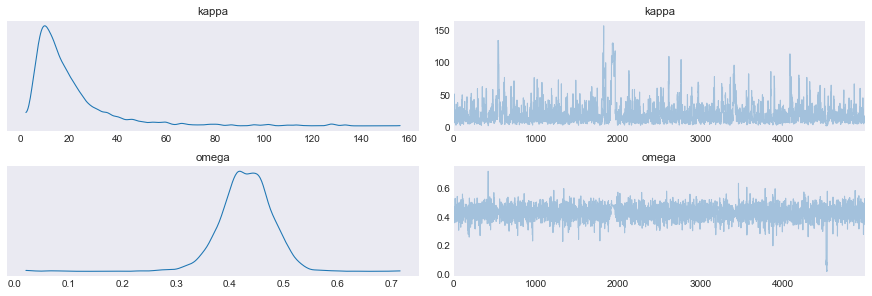

In [58]:
arviz.plot_trace({'kappa': samples['kappa'], 'omega': samples['omega']});

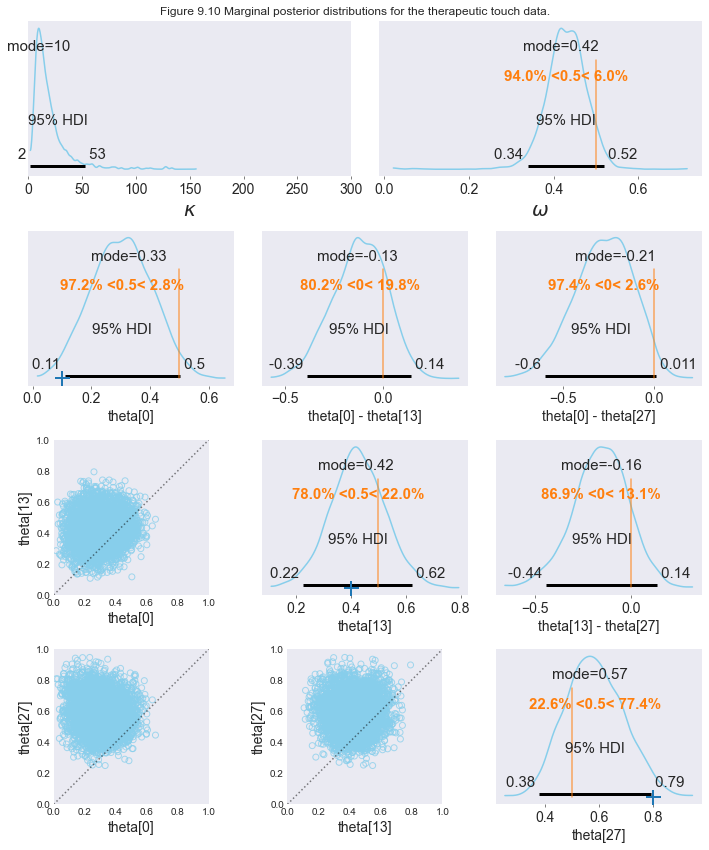

In [59]:
trace = get_samples(samples)
plot_thetas(trace, theta_obs=df_proportions)

### New Model with Logistic Transformatuon

In [163]:
def model_mcsm_logit(n_coins, y=None, coin_ids=None):
#     print(n_coins, y, coin_ids)
    """ len(y) == len(coin_id) """
    mu = numpyro.sample('mu', dist.Normal(0, .5))
#     sigma = numpyro.sample('sigma', dist.HalfCauchy(1))
#     sigma = numpyro.sample('sigma', dist.Gamma(0.01, 0.01))
    sigma = numpyro.sample('sigma', dist.Exponential(1./1.5))
    with numpyro.plate(f'N={n_coins}', size=n_coins):
        logit = numpyro.sample('logit', dist.Normal(loc=mu, scale=sigma))
        theta = numpyro.deterministic('theta', jax.scipy.special.expit(logit))
    #   
    logit_subj = logit[coin_ids]
    #
    size_y = 1 if y is None else len(y)
    with numpyro.plate(f'N={size_y}', size=size_y):
        obs = numpyro.sample('y', dist.Bernoulli(logits=logit_subj), obs=y)

#### Prior Predictive Check

In [164]:
predictive = Predictive(model_mcsm_logit, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), **dict(n_coins=n_practitioners, y=None, coin_ids=None))

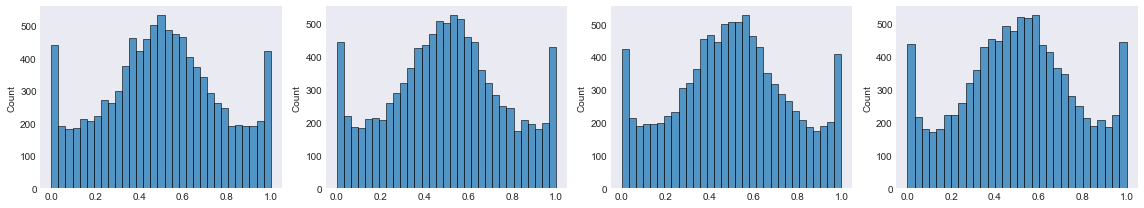

In [165]:
mu.plot_hists(samples_pred['theta'][:,:4]);  # check only 4

#### MCMC Inference

In [166]:
data_dict=dict(n_coins=n_practitioners, y=df.y.values, coin_ids=practitioner_idx)
mcmc = gomcmc(model_mcsm_logit, data_dict)

sample: 100%|██████████| 6000/6000 [00:08<00:00, 745.05it/s, 31 steps of size 1.40e-01. acc. prob=0.80] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  logit[0]     -0.46      0.35     -0.38     -1.01      0.04    191.05      1.01
  logit[1]     -0.39      0.32     -0.33     -0.90      0.08    313.13      1.01
  logit[2]     -0.33      0.29     -0.29     -0.79      0.12    603.07      1.00
  logit[3]     -0.32      0.29     -0.28     -0.80      0.13    647.63      1.00
  logit[4]     -0.32      0.28     -0.29     -0.77      0.11    682.00      1.00
  logit[5]     -0.32      0.29     -0.29     -0.81      0.12    705.81      1.00
  logit[6]     -0.32      0.29     -0.29     -0.82      0.12    620.34      1.00
  logit[7]     -0.32      0.28     -0.28     -0.77      0.12    520.83      1.00
  logit[8]     -0.33      0.29     -0.29     -0.81      0.10    486.59      1.01
  logit[9]     -0.32      0.28     -0.29     -0.78      0.12    536.37      1.00
 logit[10]     -0.26      0.27     -0.25     -0.72      0.15   1457.64      1.00
 logit[11]     -0.26      0

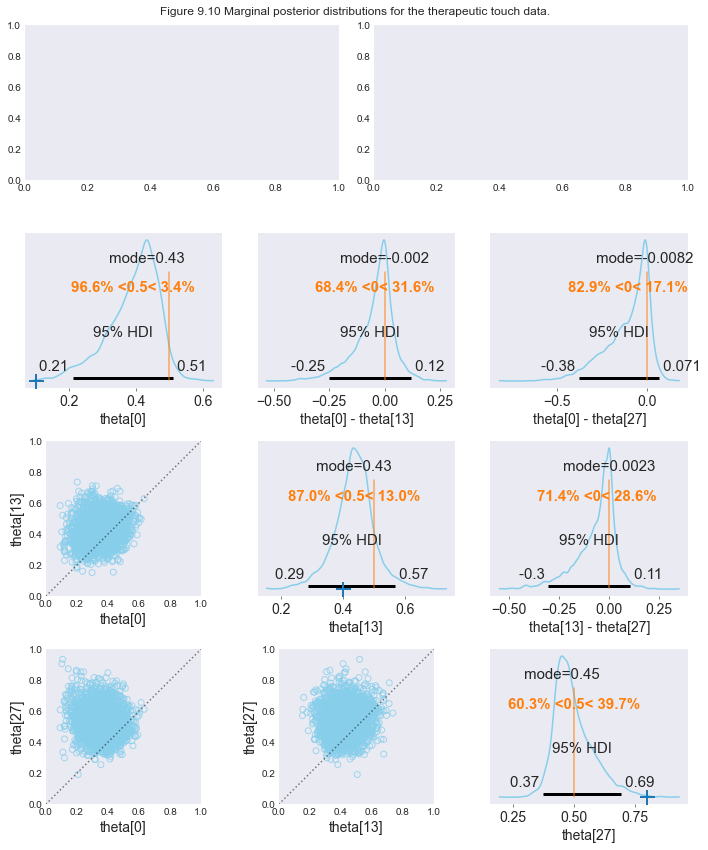

In [167]:
trace = get_samples(mcmc)
plot_thetas(trace, theta_obs=df_proportions, kappaomega=False)

End.